In [1]:
# https://www.kaggle.com/datasets/gspmoreira/articles-sharing-reading-from-cit-deskdrop?resource=download

import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('../../..')
from uncertain.utils.data import Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation import test_vanilla, test_uncertain
from uncertain.pointwise_ranking.MF import MF
from uncertain.pointwise_ranking.neural import MLP, MCDropout, Ensemble, ItemSupport, UserSupport
from uncertain.pointwise_ranking.bayesianMLP import BayesianMLP

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'Data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_table('users_interactions.csv', sep=',', header=0)
    data = data[['personId', 'contentId']].rename(columns={'personId': 'user', 'contentId': 'item'})

    # Drop user with < 5 ratings
    length = data.user.value_counts().drop(columns='timestamps')
    data.drop(data.index[data.user.isin(length.index[length < 5])], 0, inplace=True)

    data = Data(data)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=5)

data.item_support = data.item_support.astype(float)
data.user_support = data.user_support.astype(float)        

trials = 0 ## 0 for eval only mode

ImportError: cannot import name 'UncertainImplicit' from 'uncertain.pointwise_ranking.base' (/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../../../uncertain/pointwise_ranking/base.py)

In [5]:
elements = np.array([[298, 1612], [298, 9999]])
np.isin(elements, data.train)

array([[ True,  True],
       [ True, False]])

In [32]:
a = pd.DataFrame(data.train)
a.columns = ['user', 'item']
a

,user,item
0,298,1612
1,81,410
2,1151,1785
3,857,2051
4,715,2370
...,...,...
45426,1296,26
45427,1243,1769
45428,1095,1959
45429,423,2264


In [36]:
import torch
neg = pd.DataFrame({'user': a['user'].repeat(5), 'item': np.random.randint(0, data.n_item, (len(a) * 5,))})
# neg['item'][0] = 1612
neg

,user,item
0,298,564
0,298,2216
0,298,2237
0,298,1883
0,298,2141
...,...,...
45430,1072,306
45430,1072,2392
45430,1072,2067
45430,1072,1023


In [39]:
neg.isin(a)

,user,item
0,True,False
0,True,False
0,True,False
0,True,False
0,True,False
...,...,...
45430,True,False
45430,True,False
45430,True,False
45430,True,False


[0.03978577 0.05432288 0.06522571 0.07051773 0.07444104 0.07634108
 0.07776686 0.07996928 0.08109096 0.08122648]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
14,14,0.079074,2022-10-28 11:36:32.867145,2022-10-28 11:38:52.241885,0 days 00:02:19.374740,256,128,0.005421,5,0.002036,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
7,7,0.074749,2022-10-28 11:24:42.051477,2022-10-28 11:27:51.021339,0 days 00:03:08.969862,256,128,0.003454,7,0.000895,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
12,12,0.073419,2022-10-28 11:32:12.453861,2022-10-28 11:35:28.903565,0 days 00:03:16.449704,256,128,0.002193,4,0.002614,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
8,8,0.068524,2022-10-28 11:27:51.021975,2022-10-28 11:30:00.161562,0 days 00:02:09.139587,256,128,0.003494,13,0.007193,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
4,4,0.056727,2022-10-28 11:20:32.924334,2022-10-28 11:23:10.271790,0 days 00:02:37.347456,256,128,0.001352,6,0.009893,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


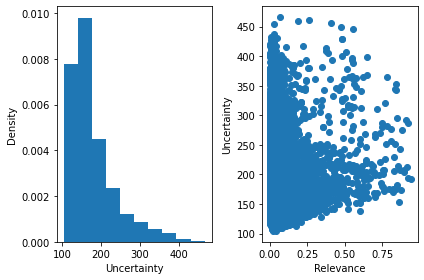

In [4]:
from uncertain.pointwise_ranking.GaussianEmbeddings import GER

# Where is the loss function?

name = 'GER'
def init_model(**kwargs):
    return GER(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'weight_decay': 0, 'n_negatives': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'weight_decay': trial.suggest_float('wd', 1e-4, 1e-1),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mf = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(mf, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.04820199 0.06426932 0.07517215 0.08012412 0.08372226 0.08604948
 0.08861761 0.08910643 0.09009417 0.09024116]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
18,18,0.076254,2022-10-30 13:29:38.447639,2022-10-30 13:31:53.456716,0 days 00:02:15.009077,256,128,0.001847,1,0.009448,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
10,10,0.070673,2022-10-30 13:23:02.729793,2022-10-30 13:24:26.162116,0 days 00:01:23.432323,256,128,0.002429,1,0.009539,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
11,11,0.070382,2022-10-30 13:24:26.162894,2022-10-30 13:25:41.015745,0 days 00:01:14.852851,256,128,0.002713,1,0.009966,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
9,9,0.067241,2022-10-30 13:22:20.829488,2022-10-30 13:23:02.728941,0 days 00:00:41.899453,256,128,0.003756,2,0.000400,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
16,16,0.059436,2022-10-30 13:28:13.432194,2022-10-30 13:29:18.604921,0 days 00:01:05.172727,256,128,0.005588,3,0.008519,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


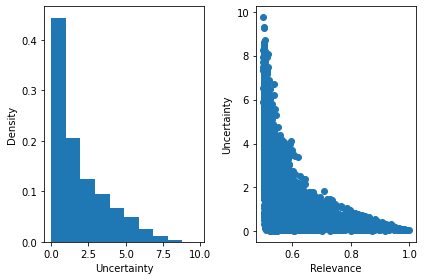

In [3]:
from uncertain.pointwise_ranking.MF import CPMF

# Where is the loss function?

name = 'CPMF'
def init_model(**kwargs):
    return CPMF(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'weight_decay': 0, 'n_negatives': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=19)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mf = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(mf, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

In [5]:
import torch
mf.predict(torch.tensor([1, 2, 3]), torch.tensor([1, 2, 3]))

/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../../../uncertain/core.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_ids = torch.tensor(user_ids)
/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../../../uncertain/core.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids)


(array([0.83363295, 0.9428265 , 0.02440012], dtype=float32),
 array([385.89127, 310.57895, 150.5343 ], dtype=float32))

In [7]:
mf.user_var.weight

Parameter containing:
tensor([[0.4964, 0.5597, 0.5900,  ..., 0.5902, 0.4423, 0.4094],
        [0.4642, 0.2083, 0.5067,  ..., 0.4513, 0.4109, 0.1129],
        [0.2415, 0.5048, 0.6139,  ..., 0.3804, 0.1941, 0.3445],
        ...,
        [0.7316, 0.7384, 0.7425,  ..., 0.7448, 0.6843, 0.5024],
        [0.7080, 0.5928, 0.7242,  ..., 0.7198, 0.5255, 0.4098],
        [0.6914, 0.7223, 0.7308,  ..., 0.7309, 0.6827, 0.6619]],
       requires_grad=True)

# MF

In [3]:
name = 'MF'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'weight_decay': 0, 'n_negatives': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'weight_decay': trial.suggest_float('wd', 1e-6, 1e-4),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mf = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mf, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.04131599 0.05967866 0.07026269 0.07472584 0.07821347 0.08106139
 0.08231349 0.08434012 0.08516716 0.08630381]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
11,11,0.076250,2022-10-21 13:45:51.811936,2022-10-21 13:47:23.954720,0 days 00:01:32.142784,256,128,0.000546,5,0.000066,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
7,7,0.076235,2022-10-21 13:42:55.455564,2022-10-21 13:43:47.209722,0 days 00:00:51.754158,256,128,0.001078,6,0.000076,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
15,15,0.072077,2022-10-21 13:50:24.660246,2022-10-21 13:52:27.709786,0 days 00:02:03.049540,256,128,0.000283,5,0.000078,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
6,6,0.071697,2022-10-21 13:42:20.386005,2022-10-21 13:42:55.454893,0 days 00:00:35.068888,256,128,0.002264,12,0.000040,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
10,10,0.068533,2022-10-21 13:44:31.783568,2022-10-21 13:45:51.811211,0 days 00:01:20.027643,256,128,0.000398,1,0.000073,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


## User support

MF-NUS - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.14386888 0.15734766 0.10886391 0.08490188 0.05506105 0.06084979
 0.04616756 0.03981959 0.04135802 0.03624661]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


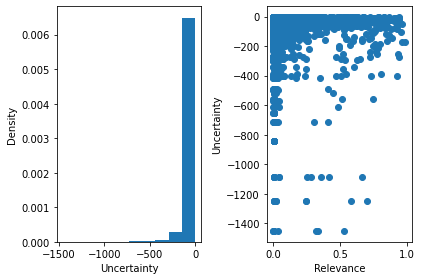

In [3]:
results = test_uncertain(UserSupport(base_MF=mf, uncertainty=-data.user_support), data, name='MF-NUS', max_k=10)
print(results['MAP-Uncertainty'])

## Item support

MF-NIS - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.07025491 0.07068873 0.08071896 0.10578619 0.05331299 0.08798942
 0.09334309 0.10991064 0.11219246 0.11279401]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


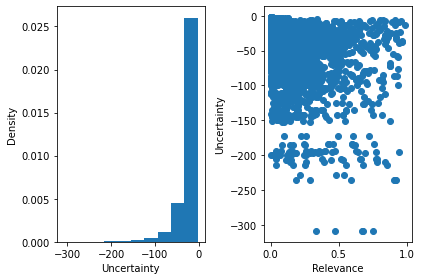

In [4]:
results = test_uncertain(ItemSupport(base_MF=mf, uncertainty=-data.item_support), data, name='MF-NIS', max_k=10)
print(results['MAP-Uncertainty'])

## Ensemble

MF-ENSEMBLE - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.04437643 0.06694721 0.07529967 0.08008162 0.08278288 0.08521848
 0.08698188 0.08777887 0.0882915  0.08893152]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


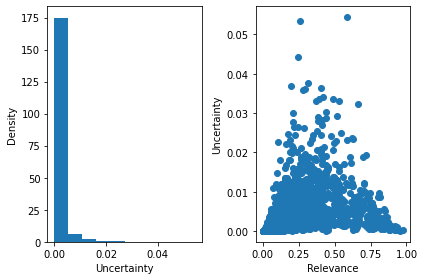

In [5]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 
               'n_negatives': best_params['neg'], 'weight_decay': best_params['wd']}

# Train
if trials > 0:
    for i in range(4):
        model = init_model(**best_params)
        train(model, data, path='checkpoints/ensemble_MF', name=f'{i}')

# Load ensemble models
models = [mf]
for file in os.listdir('checkpoints/ensemble_MF'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble_MF', file))
    models[-1].eval()
ensemble = Ensemble(models)
clear_output(wait=True)
results = test_uncertain(ensemble, data, name='MF-ENSEMBLE', max_k=10)
print(results['MAP'])

# MLP

In [6]:
name = 'MLP'
def init_model(**kwargs):
    return MLP(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'n_negatives': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 1, 20),
              'dropout': trial.suggest_float('layers', 0, 0.2)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
mlp, runs = load(init_model(**base_conf), study)
results = test_vanilla(mlp, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
runs[:5]

[0.01836266 0.02869166 0.03213466 0.03695911 0.04160716 0.04380685
 0.04522777 0.04727444 0.04741896 0.04753374]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_layers,params_lr,params_neg,user_attrs_filename,state
11,11,0.053107,2022-10-21 14:20:39.094169,2022-10-21 14:21:37.370470,0 days 00:00:58.276301,256,128,0.165183,0.008680,14,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
2,2,0.052609,2022-10-21 14:12:15.669449,2022-10-21 14:14:01.975244,0 days 00:01:46.305795,256,128,0.086056,0.005217,4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
13,13,0.051384,2022-10-21 14:22:44.809842,2022-10-21 14:24:44.032712,0 days 00:01:59.222870,256,128,0.148857,0.008073,14,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
16,16,0.050886,2022-10-21 14:27:02.418824,2022-10-21 14:28:24.493255,0 days 00:01:22.074431,256,128,0.129999,0.002733,13,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
7,7,0.050236,2022-10-21 14:17:12.146212,2022-10-21 14:18:05.000671,0 days 00:00:52.854459,256,128,0.158373,0.007491,12,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


## User support

MLP-NUS - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.08892168 0.06444252 0.05990879 0.03809836 0.04024623 0.03902439
 0.01336898 0.01452504 0.01308422 0.00574187]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


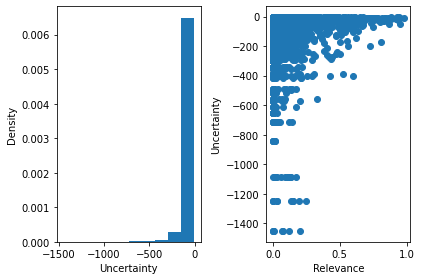

In [7]:
results = test_uncertain(UserSupport(base_MF=mlp, uncertainty=-data.user_support), data, name='MLP-NUS', max_k=10)
print(results['MAP-Uncertainty'])

## Item support

MLP-NIS - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.03262712 0.03842423 0.0491021  0.05139898 0.08884887 0.05890166
 0.06603044 0.01878531 0.03750673 0.04044256]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


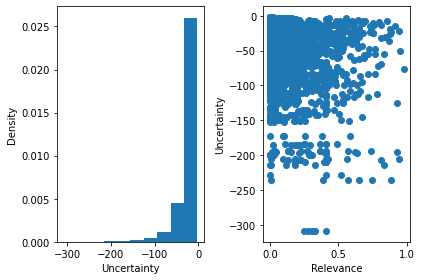

In [8]:
results = test_uncertain(ItemSupport(base_MF=mlp, uncertainty=-data.item_support), data, name='MLP-NIS', max_k=10)
print(results['MAP-Uncertainty'])

## MC Dropout

MCDropout - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.020658   0.03060444 0.03564142 0.03946697 0.04186857 0.04421491
 0.0458933  0.04776113 0.04862189 0.04986732]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


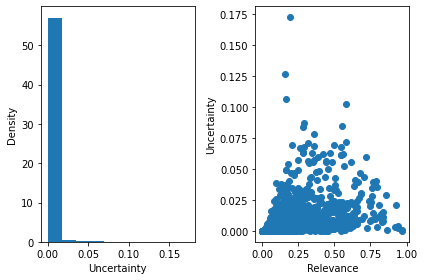

In [9]:
dropout = MCDropout(base_model=mlp, mc_iteration=5)
results = test_uncertain(dropout, data, max_k=10, name='MCDropout')
print(results['MAP'])

## Ensemble

MLP-ENSEMBLE - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.03442999 0.04667177 0.05738332 0.06424806 0.06895138 0.07152938
 0.07298794 0.07532031 0.07570029 0.0757485 ]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


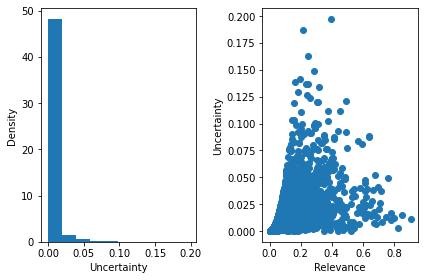

In [10]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 
               'n_negatives': best_params['neg'], 'dropout': best_params['layers']}

# Train
if trials > 0:
    for i in range(4):
        model = init_model(**best_params)
        train(model, data, path='checkpoints/ensemble_MLP', name=f'{i}')

# Load ensemble models
models = [mlp]
for file in os.listdir('checkpoints/ensemble_MLP'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble_MLP', file))
    models[-1].eval()
ensemble = Ensemble(models)
clear_output(wait=True)
results = test_uncertain(ensemble, data, name='MLP-ENSEMBLE', max_k=10)
print(results['MAP'])

# BayesianMLP

[0.03672532 0.05202754 0.05974241 0.06616085 0.06839241 0.06945508
 0.07118507 0.07367168 0.07415792 0.07504392]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_pi,params_sigma1,params_sigma2,params_train_samples,user_attrs_filename,state
13,13,0.069277,2022-10-23 05:08:04.645771,2022-10-23 05:40:54.925680,0 days 00:32:50.279909,256,128,0.004258,20,0.75,1.0,0.000335,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
14,14,0.063757,2022-10-23 05:40:54.926574,2022-10-23 06:11:44.536259,0 days 00:30:49.609685,256,128,0.002397,20,0.75,1.0,0.000335,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
12,12,0.060683,2022-10-23 04:52:14.757785,2022-10-23 05:08:04.644930,0 days 00:15:49.887145,256,128,0.005918,20,0.75,1.0,0.000912,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
3,3,0.058168,2022-10-22 13:29:58.348247,2022-10-22 13:50:19.728645,0 days 00:20:21.380398,256,128,0.004791,20,0.50,1.0,0.000912,2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
11,11,0.056997,2022-10-23 04:39:11.565805,2022-10-23 04:52:14.756928,0 days 00:13:03.191123,256,128,0.005888,20,0.25,1.0,0.000912,4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


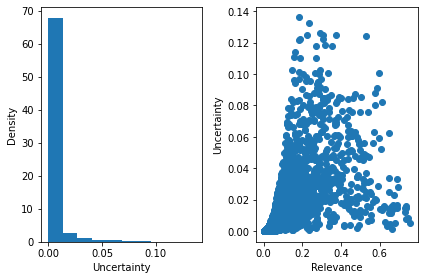

In [30]:
name = 'BayesianMLP'
def init_model(**kwargs):
    return BayesianMLP(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'n_negatives': 0, 'num_batches': int(len(data.train) / 256)}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 20, 20),
              'sample_train': trial.suggest_int('train_samples', 1, 10),
              'prior_pi': trial.suggest_categorical('pi', [1/4, 1/2, 3/4]),
              'prior_sigma_1': trial.suggest_categorical('sigma1', np.exp(-np.array([0, 1, 2]))),
              'prior_sigma_2': trial.suggest_categorical('sigma2', np.exp(-np.array([6, 7, 8])))}
    params['num_batches'] = int(len(data.train) / 256)
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=5)
BayesMLP, runs = load(init_model(**base_conf), study, top=0)
results = test_uncertain(BayesMLP, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
runs[:5]

[0.03366488 0.05049732 0.0578934  0.06303664 0.06560826 0.06949121
 0.07093581 0.07172642 0.07266376 0.0745507 ]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_pi,params_sigma1,params_sigma2,params_train_samples,user_attrs_filename,state
13,13,0.069277,2022-10-23 05:08:04.645771,2022-10-23 05:40:54.925680,0 days 00:32:50.279909,256,128,0.004258,20,0.75,1.0,0.000335,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
14,14,0.063757,2022-10-23 05:40:54.926574,2022-10-23 06:11:44.536259,0 days 00:30:49.609685,256,128,0.002397,20,0.75,1.0,0.000335,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
12,12,0.060683,2022-10-23 04:52:14.757785,2022-10-23 05:08:04.644930,0 days 00:15:49.887145,256,128,0.005918,20,0.75,1.0,0.000912,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
19,19,0.059409,2022-10-23 07:02:34.512962,2022-10-23 07:14:33.427069,0 days 00:11:58.914107,256,128,0.003445,20,0.75,1.0,0.000335,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
17,17,0.058720,2022-10-23 06:31:08.806589,2022-10-23 06:53:07.043794,0 days 00:21:58.237205,256,128,0.002211,20,0.75,1.0,0.000335,4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


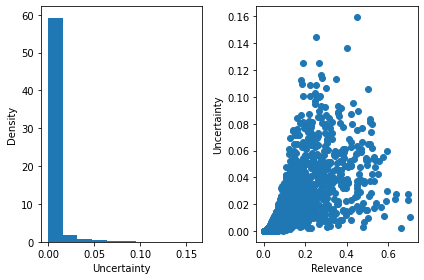

In [31]:
name = 'BayesianMLP'
def init_model(**kwargs):
    return BayesianMLP(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'n_negatives': 0, 'num_batches': int(len(data.train) / 256)}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 20, 20),
              'sample_train': trial.suggest_int('train_samples', 1, 10),
              'prior_pi': trial.suggest_categorical('pi', [1/4, 1/2, 3/4]),
              'prior_sigma_1': trial.suggest_categorical('sigma1', np.exp(-np.array([0, 1, 2]))),
              'prior_sigma_2': trial.suggest_categorical('sigma2', np.exp(-np.array([6, 7, 8])))}
    params['num_batches'] = int(len(data.train) / 256)
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=5)
BayesMLP, runs = load(init_model(**base_conf), study, top=0)
results = test_uncertain(BayesMLP, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
runs[:5]

# Results

In [4]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['MF', 'MF-NUS', 'MF-NIS', 'MF-ENSEMBLE', 'MLP', 'MLP-NUS', 'MLP-NIS', 'MLP-ENSEMBLE', 'MCDropout', 'BayesianMLP', 'GER', 'CPMF']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r', 'm']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*', 'p']
lines = {k: '-' + l for k, l, in zip(results.index, lines)}

# Results
results[['FCP', 'URI', 'UAC']]

,FCP,URI,UAC
MF,0.888128,NaN,NaN
MF-NUS,0.888128,NaN,-0.298033
MF-NIS,0.888128,0.050756,0.095426
MF-ENSEMBLE,0.894086,0.129743,0.040224
MLP,0.865634,NaN,NaN
MLP-NUS,0.865634,NaN,-0.290551
MLP-NIS,0.865634,0.312323,0.001853
MLP-ENSEMBLE,0.883510,0.109414,-0.216914
MCDropout,0.865559,0.098933,-0.127624
BayesianMLP,0.915835,0.121771,-0.092540


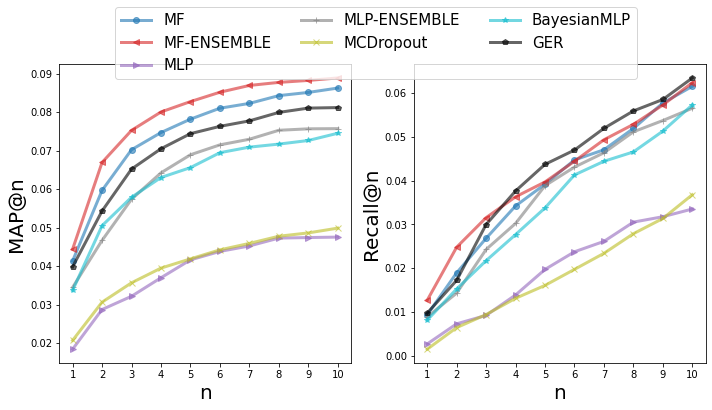

In [9]:
## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.drop(['MF-NUS', 'MF-NIS', 'MLP-NUS', 'MLP-NIS']).iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.9, 1.15))
f.tight_layout()
f.savefig('plots/accuracy.pdf')

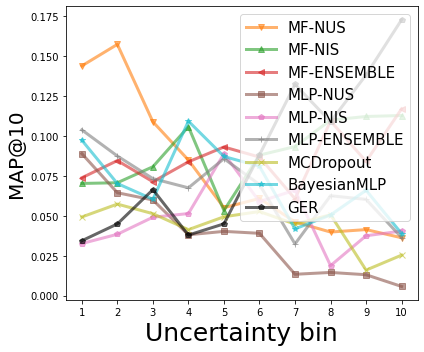

In [10]:
## MAP vs Uncertainty
f, ax = plt.subplots(figsize=(6, 5))
x = np.arange(10) + 1
for index, row in results.drop(['MF', 'MLP']).iterrows():
    ax.plot(x, row['MAP-Uncertainty'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax.set(xticks = x)
ax.set_xlabel('Uncertainty bin', fontsize=25)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/MAP-Uncertainty.pdf')

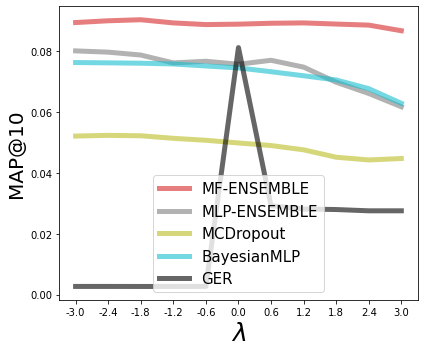

In [11]:
## MAP vs Coverage
f, ax = plt.subplots(figsize=(6, 5))
x = np.linspace(-3, 3, 11)
for index, row in results.drop(['MF', 'MLP', 'MF-NIS', 'MLP-NIS', 'MF-NUS', 'MLP-NUS']).iterrows():
    ax.plot(x, row['unc_MAP'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax.set(xticks = x, xticklabels = [str(round(x, 1)) for x in x])
ax.set_xlabel(r'$\lambda$', fontsize=25)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy_lambda.pdf')

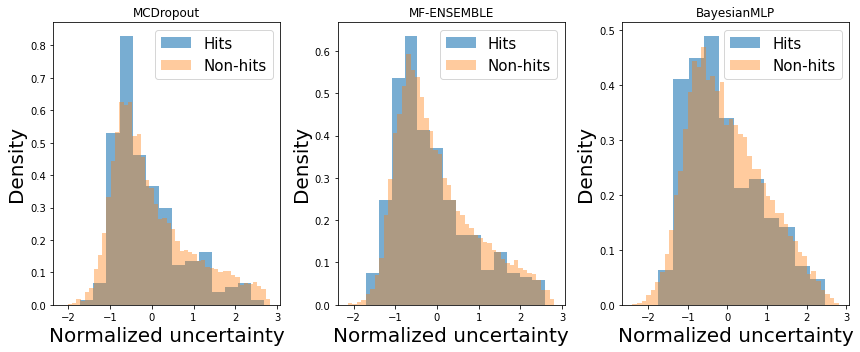

In [12]:
idx = ['MCDropout', 'MF-ENSEMBLE', 'BayesianMLP']
f, ax = plt.subplots(figsize=(12, 5), ncols=len(idx))
for i, model in enumerate(idx):
    ax[i].hist(results.loc[model]['norm_unc'][0], bins='auto', alpha=0.6, density=True, label='Hits')
    ax[i].hist(results.loc[model]['norm_unc'][1], bins='auto', alpha=0.4, density=True, label='Non-hits')
    ax[i].legend(fontsize=15)
    ax[i].set_xlabel('Normalized uncertainty', fontsize=20)
    ax[i].set_ylabel('Density', fontsize=20)
    ax[i].set_title(model)
f.tight_layout()
f.savefig('plots/normalized_uncertainty.pdf')